In [2]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [3]:
r = readers.CollectionReader('../src/beta_clip/agents')

100%|██████████| 320/320 [01:01<00:00,  5.24it/s]


In [15]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [16]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2",
          "InvertedDoublePendulum-v2"]
code_level_opts = {
      "clip_eps": [0.2]
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [17]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

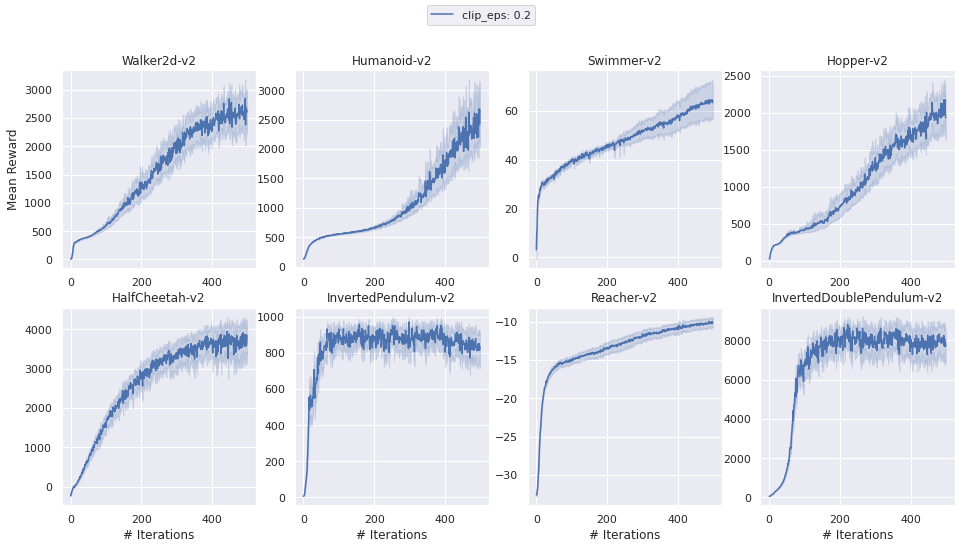

In [18]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

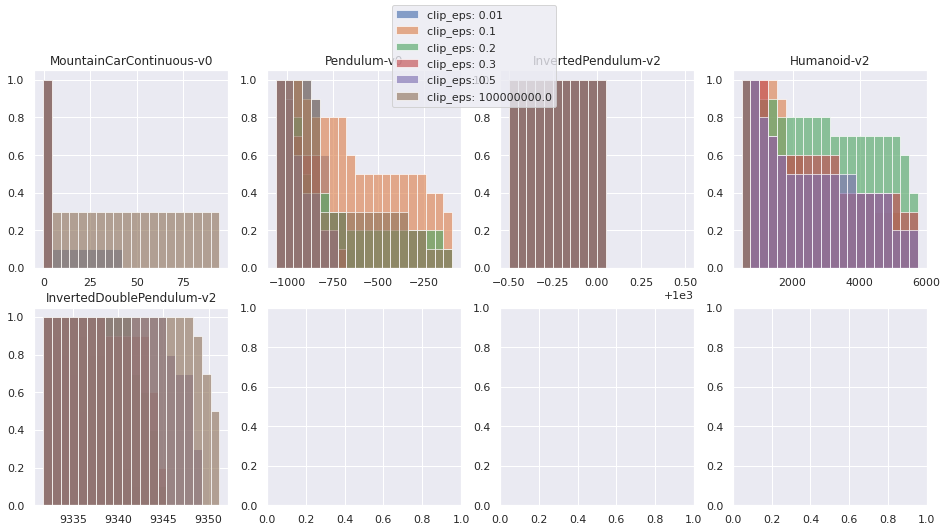

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

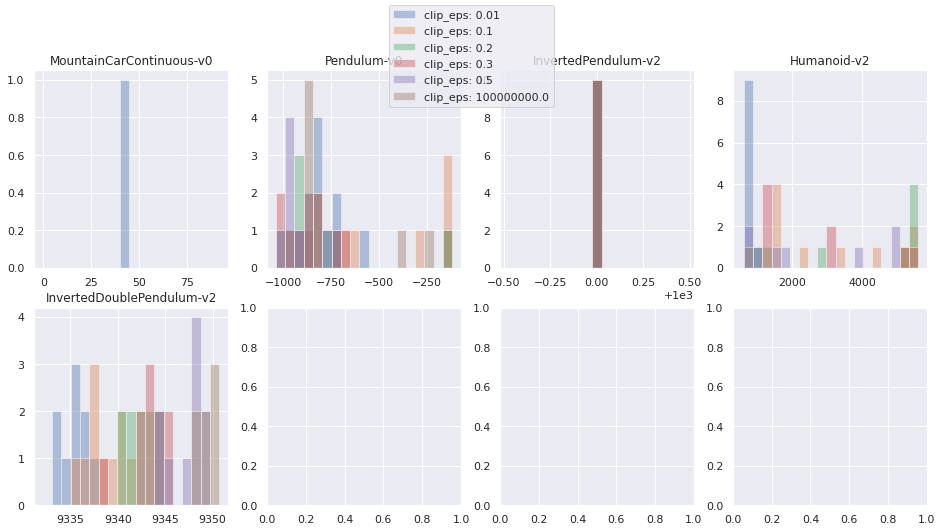

In [8]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [9]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [10]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward       stddev  \
game                      clip_eps                                            
Humanoid-v2               1.000000e-02      0       829.003787   108.376742   
                          1.000000e-01      1      3221.778727  1731.204277   
                          2.000000e-01      2      4368.466418  1889.919078   
                          3.000000e-01      3      3329.882461  2019.661913   
                          5.000000e-01      4      3104.506555  2110.807794   
                          1.000000e+08      5       538.250241    47.861951   
InvertedDoublePendulum-v2 1.000000e-02      6      9335.176040     1.807286   
                          1.000000e-01      7      9338.552012     1.971881   
                          2.000000e-01      8      9342.526000     1.510313   
                          3.000000e-01      9      9343.228478     1.953685   
                          5.000000e-01     10      9347.226693     1.673873   
                          1.000000e+08     11      9349.899804     1.106027   
MountainCarContinuous-v0  1.000000e-02     18         3.859918    13.425379   
                          1.000000e-01     19        -0.247494     0.002744   
                          2.000000e-01     20        -0.233571     0.003893   
                          3.000000e-01     21        -0.234013     0.003280   
                          5.000000e-01     22        -0.232098     0.004606   
                          1.000000e+08     23        28.142582    45.687302   
Pendulum-v0               1.000000e-02     24      -783.388012    91.043092   
                          1.000000e-01     25      -466.134064   336.789658   
                          2.000000e-01     26      -753.487743   345.428804   
                          3.000000e-01     27      -874.798511   115.830007   
                          5.000000e-01     28      -903.494666    94.511968   
                          1.000000e+08     29      -671.667767   298.747740   

                                        max_max_reward  min_max_reward  \
game                      clip_eps                                       
Humanoid-v2               1.000000e-02     5745.723917      477.714252   
                          1.000000e-01     5745.723917      477.714252   
                          2.000000e-01     5745.723917      477.714252   
                          3.000000e-01     5745.723917      477.714252   
                          5.000000e-01     5745.723917      477.714252   
                          1.000000e+08     5745.723917      477.714252   
InvertedDoublePendulum-v2 1.000000e-02     9351.197522     9331.619090   
                          1.000000e-01     9351.197522     9331.619090   
                          2.000000e-01     9351.197522     9331.619090   
                          3.000000e-01     9351.197522     9331.619090   
                          5.000000e-01     9351.197522     9331.619090   
                          1.000000e+08     9351.197522     9331.619090   
MountainCarContinuous-v0  1.000000e-02       94.444092       -0.392039   
                          1.000000e-01       94.444092       -0.392039   
                          2.000000e-01       94.444092       -0.392039   
                          3.000000e-01       94.444092       -0.392039   
                          5.000000e-01       94.444092       -0.392039   
                          1.000000e+08       94.444092       -0.392039   
Pendulum-v0               1.000000e-02      -93.907904    -1063.165758   
                          1.000000e-01      -93.907904    -1063.165758   
                          2.000000e-01      -93.907904    -1063.165758   
                          3.000000e-01      -93.907904    -1063.165758   
                          5.000000e-01      -93.907904    -1063.165758   
                          1.000000e+08      -93.907904    -1063.165758   

                                        normalized_score  no

In [11]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'clip_eps', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


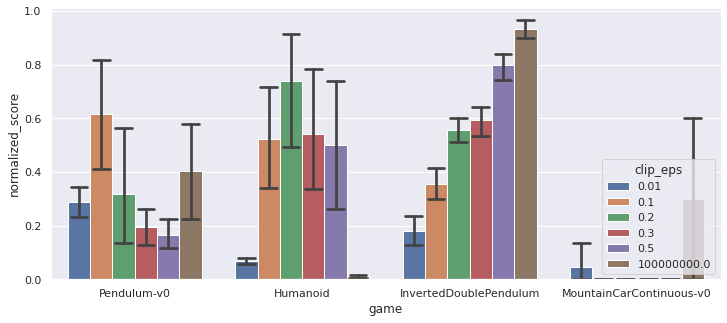

In [12]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="clip_eps", data=normalized_score.dropna().reset_index(), capsize=.1)

In [13]:
normalized_score.groupby('clip_eps').describe()

normalized_score                                          \
                        count      mean       std       min       25%   
clip_eps                                                                
1.000000e-02             40.0  0.145462  0.136037  0.000000  0.039160   
1.000000e-01             40.0  0.373124  0.333684  0.001497  0.091036   
2.000000e-01             40.0  0.404205  0.372061  0.000000  0.001722   
3.000000e-01             40.0  0.332597  0.317896  0.001622  0.022345   
5.000000e-01             40.0  0.365559  0.370851  0.001641  0.041741   
1.000000e+08             40.0  0.412502  0.436281  0.000000  0.006506   

                                            
                   50%       75%       max  
clip_eps                                    
1.000000e-02  0.103007  0.250717  0.482732  
1.000000e-01  0.319118  0.511220  0.986337  
2.000000e-01  0.405316  0.651733  1.000000  
3.000000e-01  0.229848  0.591783  0.984472  
5.000000e-01  0.197060  0.809840  1.000000  
1.000000e+08  0.213603  0.921597  1.000000